# OPTIMAL MEAL PLANNER

In [91]:
using JuMP, Gurobi, CSV, DataFrames, Plots, Statistics, StatsPlots
ENV["LC_ALL"] = "C"

"C"

# Data

In [92]:
@__DIR__() 

"/Users/alessandromorosini/Desktop/Optimization/Project/final"

## Loading

In [93]:
@__DIR__()
df = CSV.read("/Users/alessandromorosini/Desktop/Optimization/Project/final/data/nutrients.csv", DataFrame)

print(size(df))
first(df, 5)

(1083, 59)

Row,Food Code,Food Name,Description,Group,Edible proportion,Water (g),Total nitrogen (g),Protein (g),Fat (g),Carbohydrate (g),Energy (kcal) (kcal),Energy (kJ) (kJ),Starch (g),Total sugars (g),Glucose (g),Galactose (g),Fructose (g),Sucrose (g),Maltose (g),Lactose (g),Alcohol (g),NSP (g),AOAC fibre (g),Satd FA /100g fd (g),Mono FA /100g food (g),Poly FA /100g food (g),Trans FAs /100g food (g),Cholesterol (mg),Sodium (mg),Potassium (mg),Calcium (mg),Magnesium (mg),Phosphorus (mg),Iron (mg),Copper (mg),Zinc (mg),Chloride (mg),Manganese (mg),Selenium (µg),Iodine (µg),Retinol (µg),Carotene (µg),Retinol Equivalent (µg),Vitamin D (µg),Vitamin E (mg),Thiamin (mg),Riboflavin (mg),Niacin (mg),Tryptophan/60 (mg),Niacin equivalent (mg),Vitamin B6 (mg),Vitamin B12 (µg),Folate (µg),Pantothenate (mg),Biotin (µg),Vitamin C (mg),category,subcategory,Cluster
,String7,String,String,String3,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,String,String31,String15
1,14-897,"Almonds, toasted",Literature sources,GA,1.0,2.4,4.05,21.0,52.5,5.9,579.0,2394.0,0.8,5.1,0.0,0.0,0.0,5.0,0.1,0.0,0.0,0.0,10.9,4.09,33.08,12.96,0.01,0.0,3.0,713.0,268.0,279.0,471.0,3.73,1.1,3.3,18.0,2.23,2.0,2.0,0.0,1.0,15.0,0.0,23.9,0.08,1.2,3.6,3.5,7.1,0.14,0.0,55.0,0.32,49.0,0.0,Nuts and seeds,"Nuts and seeds, general",Proteins
2,14-898,"Almonds, weighed with shells",Calculated from 14-896,GA,0.37,1.6,1.51,7.8,18.5,1.9,205.0,847.0,0.3,1.6,0.1,0.0,0.6,1.5,0.0,0.0,0.0,0.9,4.6,1.41,11.67,4.56,0.01,0.0,65.0,271.0,100.0,100.0,178.0,1.37,0.38,1.2,7.0,0.81,2.0,1.0,0.0,112.0,48.0,0.0,9.48,0.08,0.42,1.3,1.3,2.6,0.05,0.0,16.0,0.17,23.7,0.0,Nuts and seeds,"Nuts and seeds, general",Vegetable
3,14-896,"Almonds, whole kernels","Literature sources, Prunus dulcis",GA,1.0,4.4,4.09,21.2,49.9,5.3,554.0,2292.0,0.8,4.5,0.2,0.1,0.1,4.1,0.0,0.0,0.0,0.0,12.5,3.8,31.55,12.33,0.02,0.0,1.0,733.0,269.0,270.0,481.0,3.71,1.031,3.1,18.0,2.18,4.0,2.0,0.0,1.0,15.0,0.0,25.63,0.21,1.14,3.6,3.4,7.0,0.14,0.0,44.0,0.47,64.0,0.0,Nuts and seeds,"Nuts and seeds, general",Proteins
4,16-448,"Anchovies, canned in oil, drained","10 samples, 4 brands",JC,0.74,46.4,4.03,25.2,10.0,0.0,191.0,798.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.6,5.3,1.8,0.1,63.0,5870.0,230.0,300.0,56.0,300.0,4.1,0.17,3.0,9100.0,0.18,15.0,12.0,57.0,25.0,57.0,0.6,0.455,0.12,0.1,3.8,4.7,8.5,0.275,11.0,18.0,0.89,3.4,0.0,Fish and fish products,Fatty fish,Proteins
5,17-851,"Apple sauce, homemade",Recipe,WC,1.0,77.5,0.04,0.3,0.2,20.2,79.0,336.0,16.9,20.2,1.6,0.0,4.8,13.7,0.0,0.0,0.0,1.3,1.4,0.05,0.02,0.11,0.06,0.0,2.0,75.0,5.0,3.0,6.0,0.11,0.03,0.0,195.5,0.02,5.0,3.0,0.0,0.0,0.0,0.0,0.1,0.03,0.01,0.1,0.1,0.2,0.04,0.0,1.0,0.41,0.7,9.0,"Soups, sauces and miscellaneous foods",Sauces,Carbs


In [94]:
df_clusters = select(df, ["Food Name", "Cluster"])

print(size(df_clusters))
first(df_clusters, 5)

(1083, 2)

Row,Food Name,Cluster
,String,String15
1,"Almonds, toasted",Proteins
2,"Almonds, weighed with shells",Vegetable
3,"Almonds, whole kernels",Proteins
4,"Anchovies, canned in oil, drained",Proteins
5,"Apple sauce, homemade",Carbs


In [95]:
calories_df = select(df, "Energy (kcal) (kcal)")

print(size(calories_df))
first(calories_df, 5)

(1083, 1)

Row,Energy (kcal) (kcal)
,Float64
1,579.0
2,205.0
3,554.0
4,191.0
5,79.0


## Pre-processing

Done in other notebooks: 
- see isma for clustering 
- see ale for missing values and outliers

## Requirements
Need to define nutrients in which we are interested, together with lower and upper bounds

Let's give sensible constraints for the total amount of nutrients we consume.

In [96]:
requirements_dict = Dict(
    "Protein (g)"        => (R=50,   U=150),
    "Fat (g)"            => (R=20,   U=100),
    "Carbohydrate (g)"   => (R=130,  U=350),
    "Total sugars (g)"   => (R=0,    U=50),
    "AOAC fibre (g)"     => (R=25,   U=70),
    "Vitamin E (mg)"     => (R=15,   U=50),
    "Vitamin C (mg)"     => (R=75,   U=200),
    "Cholesterol (mg)"   => (R=0,    U=300),
    "Sodium (mg)"        => (R=500,  U=2300)
)

nutrients = collect(keys(requirements_dict))
R_values = [requirements_dict[n].R for n in nutrients]
U_values = [requirements_dict[n].U for n in nutrients]

# Create the DataFrame
df_requirements = DataFrame(
    Nutrient = nutrients,
    R = R_values,
    U = U_values
)

Row,Nutrient,R,U
,String,Int64,Int64
1,AOAC fibre (g),25,70
2,Vitamin C (mg),75,200
3,Total sugars (g),0,50
4,Fat (g),20,100
5,Vitamin E (mg),15,50
6,Sodium (mg),500,2300
7,Cholesterol (mg),0,300
8,Protein (g),50,150
9,Carbohydrate (g),130,350


In [97]:
df_requirements.R = df_requirements.R / 2
df_requirements.U = df_requirements.U / 2

df_requirements

Row,Nutrient,R,U
,String,Float64,Float64
1,AOAC fibre (g),12.5,35.0
2,Vitamin C (mg),37.5,100.0
3,Total sugars (g),0.0,25.0
4,Fat (g),10.0,50.0
5,Vitamin E (mg),7.5,25.0
6,Sodium (mg),250.0,1150.0
7,Cholesterol (mg),0.0,150.0
8,Protein (g),25.0,75.0
9,Carbohydrate (g),65.0,175.0


In [98]:
df_nutrients  = select(df, collect(keys(requirements_dict)));
df_nutrients .= df_nutrients # ./ 100;

print(size(df_nutrients))
first(df_nutrients, 5)

(1083, 9)

Row,AOAC fibre (g),Vitamin C (mg),Total sugars (g),Fat (g),Vitamin E (mg),Sodium (mg),Cholesterol (mg),Protein (g),Carbohydrate (g)
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,10.9,0.0,5.1,52.5,23.9,3.0,0.0,21.0,5.9
2,4.6,0.0,1.6,18.5,9.48,65.0,0.0,7.8,1.9
3,12.5,0.0,4.5,49.9,25.63,1.0,0.0,21.2,5.3
4,0.0,0.0,0.0,10.0,0.455,5870.0,63.0,25.2,0.0
5,1.4,9.0,20.2,0.2,0.1,2.0,0.0,0.3,20.2


## Dataset Recap

In [99]:
print(size(df_nutrients))
first(df_nutrients, 2)

(1083, 9)

Row,AOAC fibre (g),Vitamin C (mg),Total sugars (g),Fat (g),Vitamin E (mg),Sodium (mg),Cholesterol (mg),Protein (g),Carbohydrate (g)
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,10.9,0.0,5.1,52.5,23.9,3.0,0.0,21.0,5.9
2,4.6,0.0,1.6,18.5,9.48,65.0,0.0,7.8,1.9


In [100]:
print(size(df_clusters))
first(df_clusters, 5)

(1083, 2)

Row,Food Name,Cluster
,String,String15
1,"Almonds, toasted",Proteins
2,"Almonds, weighed with shells",Vegetable
3,"Almonds, whole kernels",Proteins
4,"Anchovies, canned in oil, drained",Proteins
5,"Apple sauce, homemade",Carbs


In [101]:
print(size(calories_df))
first(calories_df, 5)

(1083, 1)

Row,Energy (kcal) (kcal)
,Float64
1,579.0
2,205.0
3,554.0
4,191.0
5,79.0


In [102]:
df_requirements

Row,Nutrient,R,U
,String,Float64,Float64
1,AOAC fibre (g),12.5,35.0
2,Vitamin C (mg),37.5,100.0
3,Total sugars (g),0.0,25.0
4,Fat (g),10.0,50.0
5,Vitamin E (mg),7.5,25.0
6,Sodium (mg),250.0,1150.0
7,Cholesterol (mg),0.0,150.0
8,Protein (g),25.0,75.0
9,Carbohydrate (g),65.0,175.0


# Formulation

## Calories Maximisation

### Maximise Calories, Discrete Food Choice 
i.e. we are not (yet) thinking about weight to consume. only maximise calories and pick at most S items. 

In [14]:
F = size(df_nutrients)[1]  # Number of different food items
K = size(df_requirements)[1]  # Number of nutrients 
C = size(unique(df_clusters.Cluster))[1]  # Number of clusters

S = 5  # maximum size, i.e. how many different items can we have at most

model = Model(Gurobi.Optimizer)
set_optimizer_attribute(model, "OutputFlag", 0)

# Binary variable for food selection
@variable(model, y[1:F], Bin)

# Constraint: At most S food items can be selected
@constraint(model, sum(y[f] for f in 1:F) <= S)

@objective(model, Max, sum(calories_df[f, 1] * y[f] for f in 1:F))

optimize!(model)


if termination_status(model) == MOI.OPTIMAL
    println("Optimal solution found!")
    y_solution = value.(y)
    selected_indices = findall(y_solution .> 0.5)  
    selected_foods = df_clusters[selected_indices, :]
    selected_calories = calories_df[selected_indices, 1]
    result_df = hcat(selected_foods, DataFrame(Calories = selected_calories))
    println("Selected foods with calories:")
    println(result_df)
else
    println("No optimal solution found.")
end

Set parameter Username
Academic license - for non-commercial use only - expires 2025-08-21
Optimal solution found!
Selected foods with calories:
5×3 DataFrame
 Row │ Food Name                         Cluster    Calories
     │ String                            String15   Float64
─────┼───────────────────────────────────────────────────────
   1 │ Bacon, fat only, average, cooked  Vegetable     692.0
   2 │ Dressing, French, homemade        Vegetable     680.0
   3 │ Ghee made from vegetable oil      Vegetable     900.0
   4 │ Hollandaise sauce, homemade       Vegetable     717.0
   5 │ Mayonnaise, standard, retail      Vegetable     686.0


### Nutritional Constraints

In [15]:
F = size(df_nutrients)[1]  # Number of different food items
K = size(df_requirements)[1]  # Number of nutrients 
C = size(unique(df_clusters.Cluster))[1]  # Number of clusters

S = 5  # maximum size, i.e. how many different items can we have at most

model = Model(Gurobi.Optimizer)
set_optimizer_attribute(model, "OutputFlag", 0)

# Binary variable for food selection
@variable(model, y[1:F], Bin)

# Constraint: At most S food items can be selected
@constraint(model, sum(y[f] for f in 1:F) <= S)

for k in 1:K
    # println("Nutrient $k:")
    # println("  Min in foods: ", minimum(df_nutrients[:, k]))
    # println("  Max in foods: ", maximum(df_nutrients[:, k]))
    # println("  Required range: ", df_requirements[k, :R], " to ", df_requirements[k, :U])
    @constraint(model, sum(df_nutrients[f, k] * y[f] for f in 1:F) >= df_requirements[k, :R])
    @constraint(model, sum(df_nutrients[f, k] * y[f] for f in 1:F) <= df_requirements[k, :U])
end

@objective(model, Max, sum(calories_df[f, 1] * y[f] for f in 1:F))

optimize!(model)


if termination_status(model) == MOI.OPTIMAL
    println("Optimal solution found!")
    y_solution = value.(y)
    selected_indices = findall(y_solution .> 0.5)  
    selected_foods = df_clusters[selected_indices, :]
    selected_calories = calories_df[selected_indices, 1]
    result_df = hcat(selected_foods, DataFrame(Calories = selected_calories))
    println("Selected foods with calories:")
    println(result_df)
else
    println("No optimal solution found.")
end

Set parameter Username
Academic license - for non-commercial use only - expires 2025-08-21
Optimal solution found!
Selected foods with calories:
5×3 DataFrame
 Row │ Food Name                          Cluster   Calories
     │ String                             String15  Float64
─────┼───────────────────────────────────────────────────────
   1 │ Beef, rump steak, grilled, lean …  Proteins     177.0
   2 │ Breakfast cereal, multigrain hoo…  Sweet        368.0
   3 │ Cod, flesh only, microwaved        Proteins      98.0
   4 │ Paratha, homemade                  Sweet        333.0
   5 │ Sev/ganthia, homemade              Sweet        478.0


### Continuous Quantities (in grams)
Note the scaling by 100

In [16]:
F = size(df_nutrients)[1]  # Number of different food items
K = size(df_requirements)[1]  # Number of nutrients 
C = size(unique(df_clusters.Cluster))[1]  # Number of clusters

S = 5  # maximum size, i.e. how many different items can we have at most
big_W = 300;

model = Model(Gurobi.Optimizer)
set_optimizer_attribute(model, "OutputFlag", 0)

# Binary variable for food selection
@variable(model, y[1:F], Bin)
# Continuous variable for food quantity (grams)
@variable(model, q[1:F] >= 0)          

@constraint(model, sum(y[f] for f in 1:F) <= 5)

# Link binary and continuous variables
@constraint(model, [f in 1:F], q[f] <= big_W * y[f])  # q[f] must be 0 if y[f] = 0

for k in 1:K
    @constraint(model, sum(df_nutrients[f, k] * q[f] / 100 for f in 1:F) >= df_requirements[k, :R])  # Lower bound
    @constraint(model, sum(df_nutrients[f, k] * q[f] / 100 for f in 1:F) <= df_requirements[k, :U])  # Upper bound
end

@objective(model, Max, sum(calories_df[f, 1] * q[f] / 100 for f in 1:F))  # Scale calories by 100

optimize!(model)

if termination_status(model) == MOI.OPTIMAL
    println("Optimal solution found!")
    y_solution = value.(y)
    q_solution = value.(q)
    selected_indices = findall(y_solution .> 0.5)  
    selected_foods = df_clusters[selected_indices, :]
    selected_quantities = q_solution[selected_indices] 
    selected_calories = [calories_df[f, 1] * q_solution[f] / 100 for f in selected_indices]  
    result_df = hcat(selected_foods, DataFrame(Quantity = selected_quantities, Calories = selected_calories))
    println("Selected foods with quantities and calories:")
    println(result_df)
else
    println("No optimal solution found.")
end

Set parameter Username
Academic license - for non-commercial use only - expires 2025-08-21
Optimal solution found!
Selected foods with quantities and calories:
5×4 DataFrame
 Row │ Food Name                          Cluster    Quantity  Calories
     │ String                             String15   Float64   Float64
─────┼──────────────────────────────────────────────────────────────────
   1 │ Beef, minced, stewed with onions…  Vegetable   271.797  307.131
   2 │ Breakfast cereal, shredded wheat…  Sweet       229.004  762.584
   3 │ Curly kale, boiled in unsalted w…  Vegetable   168.948   43.9264
   4 │ Pork chops in mustard and cream,…  Proteins    166.463  437.798
   5 │ Vinegar                            Vegetable   300.0     66.0


### Cluster Diversity

In [18]:
F = size(df_nutrients)[1]  # Number of different food items
K = size(df_requirements)[1]  # Number of nutrients 
C = size(unique(df_clusters.Cluster))[1]  # Number of clusters

S = 5  # maximum size, i.e. how many different items can we have at most
big_W = 300;

model = Model(Gurobi.Optimizer)
set_optimizer_attribute(model, "OutputFlag", 0)

# Binary variable for food selection
@variable(model, y[1:F], Bin)
# Continuous variable for food quantity (grams)
@variable(model, q[1:F] >= 0)          

@constraint(model, sum(y[f] for f in 1:F) <= 5)

# Link binary and continuous variables
@constraint(model, [f in 1:F], q[f] <= big_W * y[f])  

for k in 1:K
    @constraint(model, sum(df_nutrients[f, k] * q[f] / 100 for f in 1:F) >= df_requirements[k, :R])  # Lower bound
    @constraint(model, sum(df_nutrients[f, k] * q[f] / 100 for f in 1:F) <= df_requirements[k, :U])  # Upper bound
end

# Enforce at most X food item per cluster
clusters = unique(df_clusters[:, "Cluster"]) 
for c in clusters
    cluster_indices = findall(df_clusters[:, "Cluster"] .== c)  
    @constraint(model, sum(y[f] for f in cluster_indices) <= 2)
end

@objective(model, Max, sum(calories_df[f, 1] * q[f] / 100 for f in 1:F)) 

optimize!(model)

if termination_status(model) == MOI.OPTIMAL
    println("Optimal solution found!")
    y_solution = value.(y)
    q_solution = value.(q)
    selected_indices = findall(y_solution .> 0.5)  
    selected_foods = df_clusters[selected_indices, :]
    selected_quantities = q_solution[selected_indices] 
    selected_calories = [calories_df[f, 1] * q_solution[f] / 100 for f in selected_indices]  
    result_df = hcat(selected_foods, DataFrame(Quantity = selected_quantities, Calories = selected_calories))
    println("Selected foods with quantities and calories:")
    println(result_df)
else
    println("No optimal solution found.")
end

Set parameter Username
Academic license - for non-commercial use only - expires 2025-08-21
Optimal solution found!
Selected foods with quantities and calories:
5×4 DataFrame
 Row │ Food Name                          Cluster    Quantity  Calories
     │ String                             String15   Float64   Float64
─────┼──────────────────────────────────────────────────────────────────
   1 │ Bass, sea, flesh only, baked       Proteins    139.489   214.813
   2 │ Beef, minced, stewed with onions…  Vegetable   300.0     339.0
   3 │ Pilau, mushroom, homemade          Carbs       285.98    394.652
   4 │ Potato chips, homemade, fried in…  Carbs       294.111   579.399
   5 │ Vinegar                            Vegetable   300.0      66.0


### Capping Max Weight

In [21]:
F = size(df_nutrients)[1]  # Number of different food items
K = size(df_requirements)[1]  # Number of nutrients 
C = size(unique(df_clusters.Cluster))[1]  # Number of clusters

S = 5  # maximum size, i.e. how many different items can we have at most
big_W = 300 # maximum possible weight per item

model = Model(Gurobi.Optimizer)
set_optimizer_attribute(model, "OutputFlag", 0)

# Binary variable for food selection
@variable(model, y[1:F], Bin)
# Continuous variable for food quantity (grams)
@variable(model, q[1:F] >= 0)          

@constraint(model, sum(y[f] for f in 1:F) <= 5)

# Link binary and continuous variables
@constraint(model, [f in 1:F], q[f] <= big_W * y[f])  

for k in 1:K
    @constraint(model, sum(df_nutrients[f, k] * q[f] / 100 for f in 1:F) >= df_requirements[k, :R])  # Lower bound
    @constraint(model, sum(df_nutrients[f, k] * q[f] / 100 for f in 1:F) <= df_requirements[k, :U])  # Upper bound
end

# Enforce at most X food item per cluster
clusters = unique(df_clusters[:, "Cluster"]) 
for c in clusters
    cluster_indices = findall(df_clusters[:, "Cluster"] .== c)  
    @constraint(model, sum(y[f] for f in cluster_indices) <= 2)
end


@objective(model, Max, sum(calories_df[f, 1] * q[f] / 100 for f in 1:F)) 

optimize!(model)

if termination_status(model) == MOI.OPTIMAL
    println("Optimal solution found!")
    y_solution = value.(y)
    q_solution = value.(q)
    selected_indices = findall(y_solution .> 0.5)  
    selected_foods = df_clusters[selected_indices, :]
    selected_quantities = q_solution[selected_indices] 
    selected_calories = [calories_df[f, 1] * q_solution[f] / 100 for f in selected_indices]  
    result_df = hcat(selected_foods, DataFrame(Quantity = selected_quantities, Calories = selected_calories))
    println("Selected foods with quantities and calories:")
    println(result_df)
else
    println("No optimal solution found.")
end

Set parameter Username
Academic license - for non-commercial use only - expires 2025-08-21
Optimal solution found!
Selected foods with quantities and calories:
5×4 DataFrame
 Row │ Food Name                          Cluster    Quantity  Calories
     │ String                             String15   Float64   Float64
─────┼──────────────────────────────────────────────────────────────────
   1 │ Bass, sea, flesh only, baked       Proteins    139.489   214.813
   2 │ Beef, minced, stewed with onions…  Vegetable   300.0     339.0
   3 │ Pilau, mushroom, homemade          Carbs       285.98    394.652
   4 │ Potato chips, homemade, fried in…  Carbs       294.111   579.399
   5 │ Vinegar                            Vegetable   300.0      66.0


### Robustness (over Nutritional Values)

In [22]:
F = size(df_nutrients)[1]  # Number of different food items
K = size(df_requirements)[1]  # Number of nutrients 
C = size(unique(df_clusters.Cluster))[1]  # Number of clusters

S = 5  # maximum size, i.e. how many different items can we have at most
big_W = 200 # maximum possible weight per item
# big_M = 10000
gamma = 0.05  # 5% uncertainty

model = Model(Gurobi.Optimizer)
set_optimizer_attribute(model, "OutputFlag", 0)

# Binary variable for food selection
@variable(model, y[1:F], Bin)
# Continuous variable for food quantity (grams)
@variable(model, q[1:F] >= 0)          

@constraint(model, sum(y[f] for f in 1:F) <= 5)

# Link binary and continuous variables
@constraint(model, [f in 1:F], q[f] <= big_W * y[f])  

for k in 1:K
    # Robust lower bound: use (1 - gamma)*x[f,k] for lower nutrient scenario
    @constraint(model, sum(((1 - gamma)*df_nutrients[f, k]) * q[f] / 100 for f in 1:F) >= df_requirements[k, :R])
    # Robust upper bound: use (1 + gamma)*x[f,k] for upper nutrient scenario
    @constraint(model, sum(((1 + gamma)*df_nutrients[f, k]) * q[f] / 100 for f in 1:F) <= df_requirements[k, :U])
end

# Enforce at most X food item per cluster
clusters = unique(df_clusters[:, "Cluster"]) 
for c in clusters
    cluster_indices = findall(df_clusters[:, "Cluster"] .== c)  
    @constraint(model, sum(y[f] for f in cluster_indices) == 1)
end

# @constraint(model, [f in 1:F], q[f] <= big_W)

@objective(model, Max, sum(calories_df[f, 1] * q[f] / 100 for f in 1:F)) 

optimize!(model)

if termination_status(model) == MOI.OPTIMAL
    println("Optimal solution found!")
    y_solution = value.(y)
    q_solution = value.(q)
    selected_indices = findall(y_solution .> 0.5)  
    selected_foods = df_clusters[selected_indices, :]
    selected_quantities = q_solution[selected_indices] 
    selected_calories = [calories_df[f, 1] * q_solution[f] / 100 for f in selected_indices]  
    result_df = hcat(selected_foods, DataFrame(Quantity = selected_quantities, Calories = selected_calories))
    println("Selected foods with quantities and calories:")
    println(result_df)
else
    println("No optimal solution found.")
end

Set parameter Username
Academic license - for non-commercial use only - expires 2025-08-21
Optimal solution found!
Selected foods with quantities and calories:
4×4 DataFrame
 Row │ Food Name                          Cluster    Quantity  Calories
     │ String                             String15   Float64   Float64
─────┼──────────────────────────────────────────────────────────────────
   1 │ Beef, minced, stewed with onions…  Vegetable   200.0     226.0
   2 │ Breakfast cereal, puffed wheat, …  Sweet       188.394   642.425
   3 │ Pakora/bhajia, cauliflower, frie…  Carbs       142.982   457.542
   4 │ Pangasius, flesh only, baked       Proteins    107.761   117.459


## Weight

### Weight Minimization
also adding a minimium weight, like 10 grams if i eat an item, because i won't bother eating less for a lunch

In [23]:
F = size(df_nutrients)[1]  # Number of different food items
K = size(df_requirements)[1]  # Number of nutrients 
C = size(unique(df_clusters.Cluster))[1]  # Number of clusters

S = 5  # maximum size, i.e. how many different items can we have at most
big_W = 200 
small_W = 10
gamma = 0.05  # 5% uncertainty

model = Model(Gurobi.Optimizer)
set_optimizer_attribute(model, "OutputFlag", 0)

# Binary variable for food selection
@variable(model, y[1:F], Bin)
# Continuous variable for food quantity (grams)
@variable(model, q[1:F] >= 0)

@constraint(model, sum(y[f] for f in 1:F) <= 5)
@constraint(model, sum(y[f] for f in 1:F) <= 5)

# Link binary and continuous variables
@constraint(model, [f in 1:F], q[f] <= big_W * y[f])  

for k in 1:K
    # Robust lower bound: use (1 - gamma)*x[f,k] for lower nutrient scenario
    @constraint(model, sum(((1 - gamma)*df_nutrients[f, k]) * q[f] / 100 for f in 1:F) >= df_requirements[k, :R])
    # Robust upper bound: use (1 + gamma)*x[f,k] for upper nutrient scenario
    @constraint(model, sum(((1 + gamma)*df_nutrients[f, k]) * q[f] / 100 for f in 1:F) <= df_requirements[k, :U])
end

# Enforce at most X food item per cluster
clusters = unique(df_clusters[:, "Cluster"]) 
for c in clusters
    cluster_indices = findall(df_clusters[:, "Cluster"] .== c)  
    @constraint(model, sum(y[f] for f in cluster_indices) == 1)
end

# Enforce a minimum quantity of 10 grams if an item is eaten
@constraint(model, [f in 1:F], q[f] ≥ small_W*y[f])

@objective(model, Min, sum(q[f] for f in 1:F))  # Minimize the weight of selected foods

optimize!(model)

if termination_status(model) == MOI.OPTIMAL
    println("Optimal solution found!")
    y_solution = value.(y)
    q_solution = value.(q)
    selected_indices = findall(y_solution .> 0.5)  
    selected_foods = df_clusters[selected_indices, :]
    selected_quantities = q_solution[selected_indices] 
    selected_calories = [calories_df[f, 1] * q_solution[f] / 100 for f in selected_indices]  
    result_df = hcat(selected_foods, DataFrame(Quantity = selected_quantities, Calories = selected_calories))
    println("Selected foods with quantities and calories:")
    println(result_df)
else
    println("No optimal solution found.")
end

Set parameter Username
Academic license - for non-commercial use only - expires 2025-08-21
Optimal solution found!
Selected foods with quantities and calories:
4×4 DataFrame
 Row │ Food Name                          Cluster    Quantity  Calories
     │ String                             String15   Float64   Float64
─────┼──────────────────────────────────────────────────────────────────
   1 │ Almonds, whole kernels             Proteins    73.8097  408.906
   2 │ Beans, broad, whole, boiled in u…  Vegetable   10.0       9.1
   3 │ Breakfast cereal, malted flake, …  Sweet       70.7011  263.715
   4 │ Pakora/bhajia, potato, carrot an…  Carbs       14.9287   52.9969


### Multi-Objective
now, nost just maximise calories, but also minimise the weight
+ adding a calory requirement to try to aovid shitty meal for big values of lambda (in fact, when only trying to minimize weight we get very bad foods that have high calories but weight few like hazelnuts and wheat)

In [24]:
F = size(df_nutrients)[1]  # Number of different food items
K = size(df_requirements)[1]  # Number of nutrients 
C = size(unique(df_clusters.Cluster))[1]  # Number of clusters

S = 5  # maximum size, i.e. how many different items can we have at most
big_W = 200 # maximum possible weight per item
small_W = 10

big_M = 10000
gamma = 0.05  # 5% uncertainty

lambda = 10

model = Model(Gurobi.Optimizer)
set_optimizer_attribute(model, "OutputFlag", 0)

# Binary variable for food selection
@variable(model, y[1:F], Bin)
# Continuous variable for food quantity (grams)
@variable(model, q[1:F] >= 0)          

@constraint(model, sum(y[f] for f in 1:F) <= 5)

# Link binary and continuous variables
@constraint(model, [f in 1:F], q[f] <= big_W * y[f])  

for k in 1:K
    # Robust lower bound: use (1 - gamma)*x[f,k] for lower nutrient scenario
    @constraint(model, sum(((1 - gamma)*df_nutrients[f, k]) * q[f] / 100 for f in 1:F) >= df_requirements[k, :R])
    # Robust upper bound: use (1 + gamma)*x[f,k] for upper nutrient scenario
    @constraint(model, sum(((1 + gamma)*df_nutrients[f, k]) * q[f] / 100 for f in 1:F) <= df_requirements[k, :U])
end

# Enforce at most X food item per cluster
clusters = unique(df_clusters[:, "Cluster"]) 
for c in clusters
    cluster_indices = findall(df_clusters[:, "Cluster"] .== c)  
    @constraint(model, sum(y[f] for f in cluster_indices) == 1)
end


@constraint(model, [f in 1:F], q[f] ≥ small_W*y[f])

# Combined objective: Maximize calories and minimize weight (scaled by lambda)
@objective(model, Max, sum(calories_df[f, 1] * q[f] / 100 for f in 1:F) - lambda * sum(q[f] for f in 1:F))

optimize!(model)

if termination_status(model) == MOI.OPTIMAL
    println("Optimal solution found!")
    y_solution = value.(y)
    q_solution = value.(q)
    selected_indices = findall(y_solution .> 0.5)  
    selected_foods = df_clusters[selected_indices, :]
    selected_quantities = q_solution[selected_indices] 
    selected_calories = [calories_df[f, 1] * q_solution[f] / 100 for f in selected_indices]  
    result_df = hcat(selected_foods, DataFrame(Quantity = selected_quantities, Calories = selected_calories))
    println("Selected foods with quantities and calories:")
    println(result_df)
else
    println("No optimal solution found.")
end

Set parameter Username
Academic license - for non-commercial use only - expires 2025-08-21
Optimal solution found!
Selected foods with quantities and calories:
4×4 DataFrame
 Row │ Food Name                          Cluster    Quantity  Calories
     │ String                             String15   Float64   Float64
─────┼──────────────────────────────────────────────────────────────────
   1 │ Almonds, whole kernels             Proteins    81.3003  450.404
   2 │ Breakfast cereal, malted flake, …  Sweet       70.9963  264.816
   3 │ Curry paste                        Vegetable   10.0      25.3
   4 │ Pastry, flaky, uncooked, homemade  Carbs       10.3039   42.1428


### Pareto Analysis

In [25]:
lambdas = vcat(0:0.1:20) # , 6:1:20)
results = DataFrame(lambda=Float64[], TotalWeight=Float64[], TotalCalories=Float64[])

# If you want to store nutrient totals, create columns for each nutrient.
# Assume df_nutrients has K nutrients, you can name them N1, N2, ... or use actual names if available.
nutrient_names = ["Nutrient$(k)" for k in 1:K]
for name in nutrient_names
    results[!, name] = Float64[]
end

for lam in lambdas
    model = Model(Gurobi.Optimizer)
    set_optimizer_attribute(model, "OutputFlag", 0)
    
    @variable(model, y[1:F], Bin)
    @variable(model, q[1:F] >= 0)
    
    @constraint(model, sum(y[f] for f in 1:F) <= S)
    @constraint(model, [f in 1:F], q[f] <= big_W * y[f]) 

    # Nutrient constraints with uncertainty
    for k in 1:K
        @constraint(model, sum(((1 - gamma)*df_nutrients[f, k]) * q[f] / 100 for f in 1:F) >= df_requirements[k, :R])
        @constraint(model, sum(((1 + gamma)*df_nutrients[f, k]) * q[f] / 100 for f in 1:F) <= df_requirements[k, :U])
    end

    clusters = unique(df_clusters[:, "Cluster"]) 
    for c in clusters
        cluster_indices = findall(df_clusters[:, "Cluster"] .== c)  
        @constraint(model, sum(y[f] for f in cluster_indices) == 1)
    end

    @constraint(model, [f in 1:F], q[f] >= small_W*y[f])

    @objective(model, Max, sum(calories_df[f, 1] * q[f] / 100 for f in 1:F) - lam * sum(q[f] for f in 1:F))

    optimize!(model)

    if termination_status(model) == MOI.OPTIMAL
        q_solution = value.(q)
        total_weight = sum(q_solution)
        total_calories = sum(calories_df[f, 1] * q_solution[f] / 100 for f in 1:F)
        
        # Compute total nutrient intake for each nutrient k
        nutrient_totals = [sum((df_nutrients[f, k] * q_solution[f]) / 100 for f in 1:F) for k in 1:K]
        
        # Create a named tuple of nutrient totals using zip
        nutrient_tuple = NamedTuple(zip(Symbol.(nutrient_names), nutrient_totals))
        
        # Merge and push the row into the results DataFrame
        push!(results, merge((lambda=lam, TotalWeight=total_weight, TotalCalories=total_calories), nutrient_tuple))
    else
        # If no solution is found, record NaNs
        nutrient_nans = fill(NaN, K)
        nutrient_tuple = NamedTuple(zip(Symbol.(nutrient_names), nutrient_nans))
        push!(results, merge((lambda=lam, TotalWeight=NaN, TotalCalories=NaN), nutrient_tuple))
    end
end

Set parameter Username
Academic license - for non-commercial use only - expires 2025-08-21
Set parameter Username
Academic license - for non-commercial use only - expires 2025-08-21
Set parameter Username
Academic license - for non-commercial use only - expires 2025-08-21
Set parameter Username
Academic license - for non-commercial use only - expires 2025-08-21
Set parameter Username
Academic license - for non-commercial use only - expires 2025-08-21
Set parameter Username
Academic license - for non-commercial use only - expires 2025-08-21
Set parameter Username
Academic license - for non-commercial use only - expires 2025-08-21
Set parameter Username
Academic license - for non-commercial use only - expires 2025-08-21
Set parameter Username
Academic license - for non-commercial use only - expires 2025-08-21
Set parameter Username
Academic license - for non-commercial use only - expires 2025-08-21
Set parameter Username
Academic license - for non-commercial use only - expires 2025-08-21

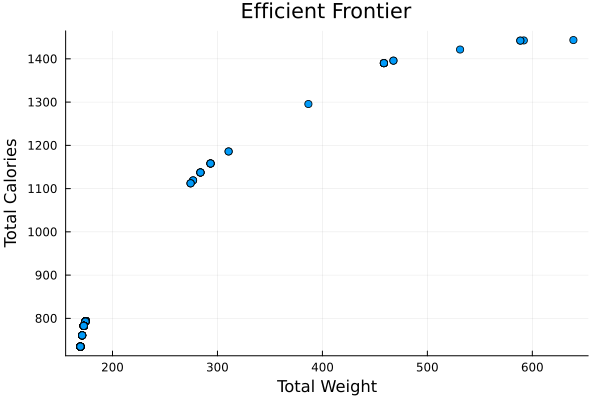

In [26]:
using Plots
@df results scatter(:TotalWeight, :TotalCalories, 
                    title="Efficient Frontier", 
                    xlabel="Total Weight", 
                    ylabel="Total Calories", 
                    label="", marker=:circle)

In [27]:
results

Row,lambda,TotalWeight,TotalCalories,Nutrient1,Nutrient2,Nutrient3,Nutrient4,Nutrient5,Nutrient6,Nutrient7,Nutrient8,Nutrient9
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,0.0,639.137,1443.43,22.0149,44.6051,5.58028,47.619,11.2044,933.429,95.3745,85.7143,166.667
2,0.1,591.853,1442.55,21.6453,40.9472,5.20779,47.619,10.2085,647.848,100.857,85.7143,166.667
3,0.2,588.563,1442.16,21.4964,39.4737,5.05774,47.619,9.8108,651.4,110.188,85.6656,166.667
4,0.3,588.563,1442.16,21.4964,39.4737,5.05774,47.619,9.8108,651.4,110.188,85.6656,166.667
5,0.4,531.179,1421.54,21.8457,39.4737,4.70461,47.619,10.7933,630.817,121.845,85.7143,166.667
6,0.5,467.665,1395.84,15.3778,39.4737,4.76053,47.619,8.24983,426.961,128.902,85.7143,166.667
7,0.6,467.665,1395.84,15.3778,39.4737,4.76053,47.619,8.24983,426.961,128.902,85.7143,166.667
8,0.7,458.585,1390.03,20.6627,39.4737,13.8576,47.619,7.97605,1074.91,131.485,84.3248,166.667
9,0.8,458.585,1390.03,20.6627,39.4737,13.8576,47.619,7.97605,1074.91,131.485,84.3248,166.667


### Pick a Lambda
Picking a very low value to get lot of calories and avoid shitty meals

In [107]:
F = size(df_nutrients)[1]  # Number of different food items
K = size(df_requirements)[1]  # Number of nutrients 
C = size(unique(df_clusters.Cluster))[1]  # Number of clusters

S = 5  # maximum size, i.e. how many different items can we have at most
big_W = 200 # maximum possible weight per item
small_W = 10

gamma = 0.08  # 5% uncertainty

lambda = 0.1

model = Model(Gurobi.Optimizer)
set_optimizer_attribute(model, "OutputFlag", 0)

# Binary variable for food selection
@variable(model, y[1:F], Bin)
# Continuous variable for food quantity (grams)
@variable(model, q[1:F] >= 0)          

@constraint(model, sum(y[f] for f in 1:F) <= 5)

# Link binary and continuous variables
@constraint(model, [f in 1:F], q[f] <= big_W * y[f])  

for k in 1:K
    # Robust lower bound: use (1 - gamma)*x[f,k] for lower nutrient scenario
    @constraint(model, sum(((1 - gamma)*df_nutrients[f, k]) * q[f] / 100 for f in 1:F) >= df_requirements[k, :R])
    # Robust upper bound: use (1 + gamma)*x[f,k] for upper nutrient scenario
    @constraint(model, sum(((1 + gamma)*df_nutrients[f, k]) * q[f] / 100 for f in 1:F) <= df_requirements[k, :U])
end

# Enforce at most X food item per cluster
clusters = unique(df_clusters[:, "Cluster"]) 
for c in clusters
    cluster_indices = findall(df_clusters[:, "Cluster"] .== c)  
    @constraint(model, sum(y[f] for f in cluster_indices) == 1)
end


@constraint(model, [f in 1:F], q[f] ≥ small_W*y[f])

# Combined objective: Maximize calories and minimize weight (scaled by lambda)
@objective(model, Max, sum(calories_df[f, 1] * q[f] / 100 for f in 1:F) - lambda * sum(q[f] for f in 1:F))

optimize!(model)

if termination_status(model) == MOI.OPTIMAL
    println("Optimal solution found!")
    y_solution = value.(y)
    q_solution = value.(q)
    selected_indices = findall(y_solution .> 0.5)  
    selected_foods = df_clusters[selected_indices, :]
    selected_quantities = q_solution[selected_indices] 
    selected_calories = [calories_df[f, 1] * q_solution[f] / 100 for f in selected_indices]  
    result_df = hcat(selected_foods, DataFrame(Quantity = selected_quantities, Calories = selected_calories))
    println("Selected foods with quantities and calories:")
    println(result_df)
else
    println("No optimal solution found.")
end

Set parameter Username
Academic license - for non-commercial use only - expires 2025-08-21
Optimal solution found!
Selected foods with quantities and calories:
4×4 DataFrame
 Row │ Food Name                          Cluster    Quantity  Calories
     │ String                             String15   Float64   Float64
─────┼──────────────────────────────────────────────────────────────────
   1 │ Breakfast cereal, puffed wheat, …  Sweet      166.996   569.455
   2 │ Pork chops in mustard and cream,…  Proteins   188.16    494.861
   3 │ Sandwich, white bread, chicken s…  Carbs      128.196   220.498
   4 │ Tomato puree                       Vegetable   85.8488   57.5187


In [108]:
result_df

Row,Food Name,Cluster,Quantity,Calories
,String,String15,Float64,Float64
1,"Breakfast cereal, puffed wheat, unfortified",Sweet,166.996,569.455
2,"Pork chops in mustard and cream, homemade",Proteins,188.16,494.861
3,"Sandwich, white bread, chicken salad",Carbs,128.196,220.498
4,Tomato puree,Vegetable,85.8488,57.5187


In [109]:
CSV.write("/Users/alessandromorosini/Desktop/Optimization/Project/final/data/single_time_results.csv", result_df)

"/Users/alessandromorosini/Desktop/Optimization/Project/final/data/single_time_results.csv"

## Dynamic Planning

### No Repetition of Food in Contiguous Meals

In [32]:
T = 2
M = 3 # 2*T
F = size(df_nutrients)[1]  # Number of different food items
K = size(df_requirements)[1]  # Number of nutrients
C = size(unique(df_clusters.Cluster))[1]  # Number of clusters

S = 5      # Maximum number of different items per meal
big_W = 300
small_W = 10
lambda = 1

model = Model(Gurobi.Optimizer)
set_optimizer_attribute(model, "OutputFlag", 0)

# Decision variables
@variable(model, y[1:F, 1:M], Bin)
@variable(model, q[1:F, 1:M] >= 0)

# At most S items per meal
@constraint(model, [m in 1:M], sum(y[f,m] for f in 1:F) <= S)

# Link binary and continuous variables
@constraint(model, [f in 1:F, m in 1:M], q[f,m] <= big_W * y[f,m])

# Nutrient constraints
@constraint(model, lower_nutrients[k in 1:K, m in 1:M], sum(df_nutrients[f, k]*q[f,m]/100 for f in 1:F) >= df_requirements[k, :R])
@constraint(model, upper_nutrients[k in 1:K, m in 1:M], sum(df_nutrients[f, k]*q[f,m]/100 for f in 1:F) <= df_requirements[k, :U])

# Cluster constraints
clusters = unique(df_clusters[:, "Cluster"])
cluster_indices_list = [findall(df_clusters[:, "Cluster"] .== c) for c in clusters]
@constraint(model, [c_i in 1:length(clusters), m in 1:M], sum(y[f,m] for f in cluster_indices_list[c_i]) == 1)

# Weight constraints
@constraint(model, [f in 1:F, m in 1:M], q[f,m] >= small_W * y[f,m])

# No same item twice in a row
@constraint(model, [f in 1:F, m in 2:M], y[f,m] + y[f,m-1] <= 1)

# Objective: Maximize total calories over all meals minus penalty on total weight
@objective(model, Max, sum(calories_df[f,1]*q[f,m]/100 for f in 1:F, m in 1:M)
                     - lambda*sum(q[f,m] for f in 1:F, m in 1:M))

optimize!(model)

if termination_status(model) == MOI.OPTIMAL
    println("Optimal solution found!")
    y_solution = value.(y)
    q_solution = value.(q)

    for m in 1:M
        selected_indices = findall(y_solution[:,m] .> 0.5)
        selected_foods = df_clusters[selected_indices, :]
        selected_quantities = q_solution[selected_indices,m]
        selected_calories = [calories_df[f, 1] * q_solution[f,m] / 100 for f in selected_indices]
        result_df = hcat(selected_foods, DataFrame(Quantity = selected_quantities, Calories = selected_calories))
        println("Meal $m:")
        println(result_df)
    end
else
    println("No optimal solution found.")
end

Set parameter Username
Academic license - for non-commercial use only - expires 2025-08-21
Optimal solution found!
Meal 1:
4×4 DataFrame
 Row │ Food Name                          Cluster    Quantity  Calories
     │ String                             String15   Float64   Float64
─────┼──────────────────────────────────────────────────────────────────
   1 │ Breakfast cereal, puffed wheat, …  Sweet      223.486   762.088
   2 │ Cheese, Parmesan, fresh            Proteins   149.988   622.449
   3 │ Potato products, shaped, frozen,…  Carbs       10.0      19.0
   4 │ Tomato puree                       Vegetable   76.9767   51.5744
Meal 2:
4×4 DataFrame
 Row │ Food Name                          Cluster    Quantity  Calories
     │ String                             String15   Float64   Float64
─────┼──────────────────────────────────────────────────────────────────
   1 │ Crackers, wholemeal, homemade      Sweet      203.47    856.609
   2 │ Pakora/bhajia, cauliflower, frie…  Carbs      10

### Penalizing Repetitions

In [35]:
using JuMP
using Gurobi
using DataFrames

T = 1
M = 3
F = size(df_nutrients)[1]
K = size(df_requirements)[1]
C = size(unique(df_clusters.Cluster))[1]

S = 5
big_W = 300
small_W = 10
lambda = 1
α = 50.0  # Penalty coefficient for repetition

model = Model(Gurobi.Optimizer)
set_optimizer_attribute(model, "OutputFlag", 0)

@variable(model, y[1:F, 1:M], Bin)
@variable(model, q[1:F, 1:M] >= 0)

# At most S items per meal
@constraint(model, [m in 1:M], sum(y[f,m] for f in 1:F) <= S)

# Link binary and continuous
@constraint(model, [f in 1:F, m in 1:M], q[f,m] ≤ big_W * y[f,m])

# Nutrient constraints
@constraint(model, lower_nutrients[k in 1:K, m in 1:M], sum(df_nutrients[f,k] * q[f,m]/100 for f in 1:F) ≥ df_requirements[k, :R])
@constraint(model, upper_nutrients[k in 1:K, m in 1:M], sum(df_nutrients[f,k] * q[f,m]/100 for f in 1:F) ≤ df_requirements[k, :U])

# Cluster constraints: exactly one item per cluster per meal
clusters = unique(df_clusters[:, "Cluster"])
cluster_indices_list = [findall(df_clusters[:, "Cluster"] .== c) for c in clusters]
@constraint(model, [c_i in 1:length(clusters), m in 1:M], sum(y[f,m] for f in cluster_indices_list[c_i]) == 1)

# Weight constraints
# @constraint(model, [f in 1:F, m in 1:M], q[f,m] ≤ big_W)
@constraint(model, [f in 1:F, m in 1:M], q[f,m] ≥ small_W * y[f,m])

# No same item twice in a row
@constraint(model, [f in 1:F, m in 2:M], y[f,m] + y[f,m-1] ≤ 1)

# Introduce repetition variables
@variable(model, r[1:F] ≥ 0)

# r_f ≥ (sum_m y_f,m) - 1
@constraint(model, [f in 1:F], r[f] ≥ sum(y[f,m] for m in 1:M) - 1)

# Objective: maximize calories - lambda * weight - α * repetition penalty
@objective(model, Max, sum(calories_df[f,1]*q[f,m]/100 for f in 1:F, m in 1:M)
                     - lambda*sum(q[f,m] for f in 1:F, m in 1:M)
                     - α*sum(r[f] for f in 1:F))

optimize!(model)

if termination_status(model) == MOI.OPTIMAL
    println("Optimal solution found!")
    y_solution = value.(y)
    q_solution = value.(q)

    for m in 1:M
        selected_indices = findall(y_solution[:,m] .> 0.5)
        selected_foods = df_clusters[selected_indices, :]
        selected_quantities = q_solution[selected_indices,m]
        selected_calories = [calories_df[f,1]*q_solution[f,m]/100 for f in selected_indices]
        
        result_df = hcat(selected_foods, DataFrame(Quantity = selected_quantities, Calories = selected_calories))
        println("Meal $m:")
        println(result_df)
    end
else
    println("No optimal solution found.")
end

Set parameter Username
Academic license - for non-commercial use only - expires 2025-08-21
Optimal solution found!
Meal 1:
4×4 DataFrame
 Row │ Food Name                          Cluster    Quantity  Calories
     │ String                             String15   Float64   Float64
─────┼───────────────────────────────────────────────────────────────────
   1 │ Broccoli, green, steamed           Vegetable   61.5338    20.9215
   2 │ Cream crackers                     Sweet      235.967   1050.06
   3 │ Pakora/bhajia, potato, carrot an…  Carbs       28.9861   102.901
   4 │ Venison, roast                     Proteins   176.553    291.312
Meal 2:
4×4 DataFrame
 Row │ Food Name                          Cluster    Quantity  Calories
     │ String                             String15   Float64   Float64
─────┼───────────────────────────────────────────────────────────────────
   1 │ Crackers, wholemeal, homemade      Sweet      206.573   869.674
   2 │ Pakora/bhajia, cauliflower, frie…  Carbs 

### Cumulative Requirements

In [110]:
using DataFrames, Gurobi, JuMP

# Given parameters and data
T = 1
M = 4
F = size(df_nutrients)[1]
K = size(df_requirements)[1]
C = size(unique(df_clusters.Cluster))[1]

S = 5
big_W = 300
small_W = 10
lambda = 1
α = 50.0
δ = 0.5
lower_factor = 0.95
upper_factor = 1.05

model = Model(Gurobi.Optimizer)
set_optimizer_attribute(model, "OutputFlag", 0)

@variable(model, y[1:F, 1:M], Bin)
@variable(model, q[1:F, 1:M] >= 0)
@variable(model, r[1:F] >= 0)

# Robust nutrient store variables
@variable(model, sL[1:K, 0:M] >= 0)
@variable(model, sU[1:K, 0:M] >= 0)

######################
# Constraints
######################

# At most S items per meal
@constraint(model, [m in 1:M], sum(y[f,m] for f in 1:F) ≤ S)

# Link binary and continuous vars
@constraint(model, [f in 1:F, m in 1:M], q[f,m] ≤ big_W * y[f,m])

# Cluster constraints
clusters = unique(df_clusters[:, "Cluster"])
cluster_indices_list = [findall(df_clusters[:, "Cluster"] .== c) for c in clusters]
@constraint(model, [c_i in 1:length(clusters), m in 1:M], sum(y[f,m] for f in cluster_indices_list[c_i]) == 1)

# Portion size constraints
@constraint(model, [f in 1:F, m in 1:M], q[f,m] ≥ small_W * y[f,m])

# No same item twice in a row
@constraint(model, [f in 1:F, m in 2:M], y[f,m] + y[f,m-1] ≤ 1)

# Repetition penalty constraints
@constraint(model, [f in 1:F], r[f] ≥ sum(y[f,m] for m in 1:M) - 1)

# Initial conditions for nutrient stores
@constraint(model, [k in 1:K], sL[k,0] == 0)
@constraint(model, [k in 1:K], sU[k,0] == 0)

# Update rules under worst-case assumptions
@constraint(model, [k in 1:K, m in 1:M],
    sL[k,m] == δ * sL[k,m-1] + sum((lower_factor * df_nutrients[f,k]/100)*q[f,m] for f in 1:F))
@constraint(model, [k in 1:K, m in 1:M],
    sU[k,m] == δ * sU[k,m-1] + sum((upper_factor * df_nutrients[f,k]/100)*q[f,m] for f in 1:F))

# Robust feasibility constraints
@constraint(model, [k in 1:K, m in 1:M], sL[k,m] ≥ df_requirements[k, :R])
@constraint(model, [k in 1:K, m in 1:M], sU[k,m] ≤ df_requirements[k, :U])

######################
# Objective
######################
@objective(model, Max, sum(calories_df[f,1]*q[f,m]/100 for f in 1:F, m in 1:M)
                     - lambda * sum(q[f,m] for f in 1:F, m in 1:M)
                     - α * sum(r[f] for f in 1:F))

optimize!(model)

if termination_status(model) == MOI.OPTIMAL
    println("Optimal solution found!")
    y_solution = value.(y)
    q_solution = value.(q)

    for m in 1:M
        selected_indices = findall(y_solution[:,m] .> 0.5)
        selected_foods = df_clusters[selected_indices, :]
        selected_quantities = q_solution[selected_indices,m]
        selected_calories = [calories_df[f,1]*q_solution[f,m]/100 for f in selected_indices]

        result_df = hcat(selected_foods, DataFrame(Quantity = selected_quantities, Calories = selected_calories))
        println("Meal $m:")
        println(result_df)
    end
else
    println("No optimal solution found.")
end

Set parameter Username
Academic license - for non-commercial use only - expires 2025-08-21
Optimal solution found!
Meal 1:
4×4 DataFrame
 Row │ Food Name                          Cluster    Quantity  Calories
     │ String                             String15   Float64   Float64
─────┼───────────────────────────────────────────────────────────────────
   1 │ Breakfast cereal, puffed wheat, …  Sweet      218.094   743.702
   2 │ Cheese, Parmesan, fresh            Proteins   115.424   479.01
   3 │ Pepper, capsicum, red, boiled in…  Vegetable   44.3525    7.53992
   4 │ Salad cream                        Carbs       33.4527  109.056
Meal 2:
4×4 DataFrame
 Row │ Food Name                          Cluster    Quantity  Calories
     │ String                             String15   Float64   Float64
─────┼───────────────────────────────────────────────────────────────────
   1 │ Broccoli, green, steamed           Vegetable   11.5152    3.91518
   2 │ Crackers, wholemeal, homemade      Sweet  

### Different Depletion Rates

In [118]:
using JuMP
using Gurobi
using DataFrames

# Example depletion rates for each nutrient
# Nutrients that persist (fat-soluble, fats, cholesterol): δ = 0.5
# Nutrients that vanish between meals (water-soluble, carbs, sodium, etc.): δ = 0.0
delta_dict = Dict(
    "Protein (g)"        => 0.0,
    "Fat (g)"            => 0.5,
    "Carbohydrate (g)"   => 0.0,
    "Total sugars (g)"   => 0.0,
    "AOAC fibre (g)"     => 0.0,
    "Vitamin E (mg)"     => 0.5,
    "Vitamin C (mg)"     => 0.0,
    "Cholesterol (mg)"   => 0.5,
    "Sodium (mg)"        => 0.0
)

γ = 0.05 # Uncertainty parameter
M = 4
S = 5
big_W = 300
small_W = 10
lambda = 1
α = 50.0

model = Model(Gurobi.Optimizer)
set_optimizer_attribute(model, "OutputFlag", 0)

F = size(df_nutrients)[1]
K = size(df_requirements)[1]
clusters = unique(df_clusters[:, "Cluster"])
cluster_indices_list = [findall(df_clusters[:, "Cluster"] .== c) for c in clusters]

@variable(model, y[1:F, 1:M], Bin)
@variable(model, q[1:F, 1:M] >= 0)

@constraint(model, [m in 1:M], sum(y[f,m] for f in 1:F) <= S)
@constraint(model, [f in 1:F, m in 1:M], q[f,m] ≤ big_W * y[f,m])
@constraint(model, [f in 1:F, m in 1:M], q[f,m] ≥ small_W * y[f,m])

@constraint(model, [c_i in 1:length(clusters), m in 1:M], sum(y[f,m] for f in cluster_indices_list[c_i]) == 1)
@constraint(model, [f in 1:F, m in 2:M], y[f,m] + y[f,m-1] ≤ 1)

@variable(model, r[1:F] ≥ 0)
@constraint(model, [f in 1:F], r[f] ≥ sum(y[f,m] for m in 1:M) - 1)

# Nutrient stores
@variable(model, sL[1:K, 0:M] ≥ 0)
@variable(model, sU[1:K, 0:M] ≥ 0)

# Initial conditions
@constraint(model, [k in 1:K], sL[k,0] == 0)
@constraint(model, [k in 1:K], sU[k,0] == 0)

# Update rules for nutrient stores
for k in 1:K
    nutrient_name = df_requirements[k, :Nutrient]
    δ = delta_dict[nutrient_name]
    for m in 1:M
        @constraint(model,
            sL[k,m] == δ * sL[k,m-1] + sum((1 - γ)*df_nutrients[f,k]/100 * q[f,m] for f in 1:F))
        @constraint(model,
            sU[k,m] == δ * sU[k,m-1] + sum((1 + γ)*df_nutrients[f,k]/100 * q[f,m] for f in 1:F))
    end
end

# Robust feasibility constraints
@constraint(model, [k in 1:K, m in 1:M], sL[k,m] ≥ df_requirements[k, :R])
@constraint(model, [k in 1:K, m in 1:M], sU[k,m] ≤ df_requirements[k, :U])

@objective(model, Max, sum(calories_df[f,1]*q[f,m]/100 for f in 1:F, m in 1:M)
                     - lambda*sum(q[f,m] for f in 1:F, m in 1:M)
                     - α*sum(r[f] for f in 1:F))

optimize!(model)

if termination_status(model) == MOI.OPTIMAL
    println("Optimal solution found!")
    y_solution = value.(y)
    q_solution = value.(q)
    sL_solution = value.(sL)
    sU_solution = value.(sU)

    for m in 1:M
        selected_indices = findall(y_solution[:,m] .> 0.5)
        selected_foods = df_clusters[selected_indices, :]
        selected_quantities = q_solution[selected_indices,m]
        selected_calories = [calories_df[f,1]*q_solution[f,m]/100 for f in selected_indices]

        result_df = hcat(selected_foods, DataFrame(Quantity = selected_quantities, Calories = selected_calories))
        println("Meal $m:")
        println(result_df)
    end

    println("sL values:")
    println(sL_solution)

    println("sU values:")
    println(sU_solution)
else
    println("No optimal solution found.")
end


Set parameter Username
Academic license - for non-commercial use only - expires 2025-08-21
Optimal solution found!
Meal 1:
4×4 DataFrame
 Row │ Food Name                          Cluster    Quantity  Calories
     │ String                             String15   Float64   Float64
─────┼──────────────────────────────────────────────────────────────────
   1 │ Almonds, weighed with shells       Vegetable    10.0      20.5
   2 │ Pakora/bhajia, cauliflower, frie…  Carbs       146.372   468.391
   3 │ Pork, diced, kebabs, grilled, le…  Proteins    102.268   204.536
   4 │ Wafers, plain ice cream wafers, …  Sweet       175.454   645.671
Meal 2:
4×4 DataFrame
 Row │ Food Name                          Cluster    Quantity  Calories
     │ String                             String15   Float64   Float64
─────┼───────────────────────────────────────────────────────────────────
   1 │ Beans, red kidney, dried, boiled…  Carbs       10.0      10.0
   2 │ Crackers, wholemeal, homemade      Sweet      